In [42]:
from pandas.core.frame import DataFrame
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import (GradientBoostingClassifier, GradientBoostingRegressor,RandomForestClassifier, RandomForestRegressor)
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
# from xgboost import XGBClassifier
from sklearn.metrics import precision_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random

In [43]:
excelFile = r'Geri-DL-data/EncodingFeature_NoMissing.xlsx'
features = pd.DataFrame(pd.read_excel(excelFile))

In [45]:
features.shape

(7584, 63)

In [6]:
excelFile = r'Geri-DL-data/EncodingOutcomes_NoMissing.xlsx'
Outcomes = pd.DataFrame(pd.read_excel(excelFile))

In [7]:
fallAssessment=Outcomes['outcome-Mds-fall-since-prior-assessment']
dataset=features
dataset['target']=fallAssessment

In [170]:
dataset.isnull().any()

patient-id                                                                                                          False
episodeTime                                                                                                         False
stayDays                                                                                                            False
current-stay-days                                                                                                   False
cumulative-days-in-facility                                                                                         False
cms-long-stay                                                                                                       False
mds-stay-trans-short-to-long                                                                                        False
age                                                                                                                 False
gender                  

In [260]:
# o=groupById(dataset)
# print(o.size())   # check how many records for each patient id
# print(o.size().index)
# Pid_count=pd.DataFrame(o.size())
# Pid_count
# groupById(dataset).size().index
# ymat

In [10]:
def groupById(data, col='patient-id'):
    g = data.groupby(col)
    print 'Number of unique IDs: %d\n' % len(g)
    return g

In [188]:
def generate_frame(df):
    x, y = list(), list()
    index = groupById(df).size().index
    for idx in index:
        dff = df[df['patient-id']==idx]
        dff.drop('patient-id', axis=1, inplace=True)
        y.append(dff['target'])
        dff.drop('target', axis=1, inplace=True)
        x.append([value for value in dff.values])
    return x, y

In [189]:
xmat, ymat = generate_frame(dataset)

Number of unique IDs: 3133



In [327]:
def train_test_split(xmat, ymat, radio, seed):
    random.seed(seed)
    n_total = sum(y.shape[0] for y in ymat)
    print('total number of samples: %d' % n_total)
    X_train, X_test, Y_train, Y_test = ([], ) * 4
    idx = random.sample(range(len(ymat)), len(ymat))
    n_train = 0
    for i,val in enumerate(idx):
        n_train += len(ymat[val])
        if(n_train >= n_total * radio):
            X_train, Y_train = [xmat[j] for j in idx[:i]], [ymat[j] for j in idx[:i]]
            X_test, Y_test = [xmat[j] for j in idx[i:]], [ymat[j] for j in idx[i:]]
            print('total number of samples in training set: %d' % n_train)
            break
    return X_train, X_test, Y_train, Y_test

In [332]:
# Method 1
# def train_test_split_by_patient(xmat, ymat, radio, seed):
#     random.seed(seed)
#     idx = random.sample(range(len(ymat)), len(ymat))
#     i = int(len(ymat) * radio)
#     X_train, Y_train = [xmat[j] for j in idx[:i]], [ymat[j] for j in idx[:i]]
#     X_test, Y_test = [xmat[j] for j in idx[i:]], [ymat[j] for j in idx[i:]]
#     return X_train, X_test, Y_train, Y_test

# Method 2
def train_test_split_by_patient(xmat, ymat, radio, seed):
    random.seed(seed)
    n_patientTotal=len(ymat)
    print('total number of patient samples: %d' % n_patientTotal)
    idx = random.sample(range(len(ymat)), len(ymat))
    n_patient = 0
    for i,val in enumerate(idx):
        n_patient +=1
        if(n_patient >= n_patientTotal * radio):
            X_train, Y_train = [xmat[j] for j in idx[:i]], [ymat[j] for j in idx[:i]]
            X_test, Y_test = [xmat[j] for j in idx[i:]], [ymat[j] for j in idx[i:]]
            print('total number of patients in training set: %d' % n_patient)
            break
    return X_train, X_test, Y_train, Y_test

In [328]:
X_train, X_test, Y_train, Y_test = train_test_split(xmat, ymat, 0.7, 1)

total number of samples: 7584
total number of samples in training set: 5309


In [335]:
X_train, X_test, Y_train, Y_test = train_test_split_by_patient(xmat, ymat, 0.7, 1)

total number of patient samples: 3133
total number of patients in training set: 2194


In [336]:
from pprint import pprint
from itertools import chain

In [337]:
# Method 1
# pprint([[item] for item in chain.from_iterable(xmat)])
# list_arrays=list(chain.from_iterable(X_train))
# X_train_df=pd.DataFrame(np.row_stack(list_arrays))

# Method 2
# list_arrays = [layer3 for layer2 in layer1 for layer3 in layer2]
# pd.DataFrame(np.row_stack(list_arrays))

# unwrap lists and store records in dataframe  
def patientListToDF (lists):
    list_arrays=list(chain.from_iterable(lists))
    return pd.DataFrame(np.row_stack(list_arrays))
    

In [338]:
X_train_df=patientListToDF(X_train)
Y_train_df=patientListToDF(Y_train)
X_test_df=patientListToDF(X_test)
Y_test_df=patientListToDF(Y_test)

In [339]:
## set column names for the output dataframe
# data=dataset.drop(columns=['patient-id','target'])
X_train_df.columns=data.columns
X_test_df.columns=data.columns
Y_test_df.columns=['target']
Y_train_df.columns=['target']

In [ ]:
#############################################
# models

In [340]:
from sklearn import preprocessing ## for standarScaler
import sklearn
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score

In [ ]:
# Logistic regression 

In [354]:
scaler=preprocessing.StandardScaler().fit(X_train_df) 
X_train_transformed=scaler.transform(X_train_df) #apply scaling on training set
X_test_transformed=scaler.transform(X_test_df) #apply scaling on test set

In [355]:
# Logistic regression 
## fit the model
FittedLogRegModel2= LogisticRegression(C=1).fit(X_train_transformed,Y_train_df.values.ravel())
predictions2=FittedLogRegModel2.predict(X_test_transformed)

## make predcitions with scaled features and get the accuracy
accuracy2=accuracy_score(Y_test_df,predictions2)
print('After doing the scaling, the accuracy of the model is:',accuracy2)

('After doing the scaling, the accuracy of the model is:', 0.798513986013986)


In [342]:
confusion_matrix(Y_test_df, predictions2)

array([[1815,   13],
       [ 448,   12]])

In [343]:
print("Precision", sklearn.metrics.precision_score(Y_test_df, predictions2))
print( "Recall", sklearn.metrics.recall_score(Y_test_df, predictions2))
print( "f1_score", sklearn.metrics.f1_score(Y_test_df, predictions2))

('Precision', 0.48)
('Recall', 0.02608695652173913)
('f1_score', 0.04948453608247423)


In [344]:
fpr, tpr, tresholds = sklearn.metrics.roc_curve(Y_test_df, predictions2)
print('fpr',fpr) # True Positive Rate , TPR=TP/(TP+FN),sensitivity 
print('tpr',tpr) # False Positive Rate , FPR=FP /（FP + TN）
print('tresholds',tresholds)
roc_auc = sklearn.metrics.auc(fpr,tpr)
print('auc', roc_auc)

('fpr', array([0.       , 0.0071116, 1.       ]))
('tpr', array([0.        , 0.02608696, 1.        ]))
('tresholds', array([2, 1, 0]))
('auc', 0.5094876795737799)


<Figure size 432x288 with 0 Axes>

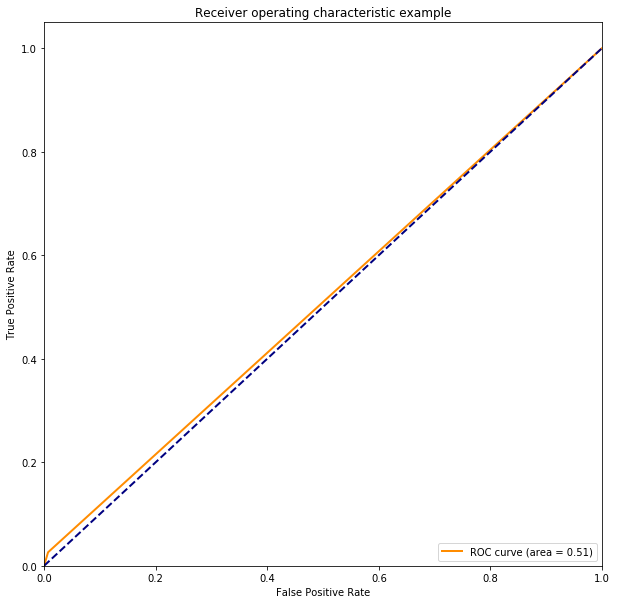

In [345]:
plt.figure()
lw = 2
plt.figure(figsize=(10,10))
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [ ]:
## SVC model

In [346]:
from sklearn.svm import SVC
from sklearn.datasets import load_breast_cancer
#from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler 
from sklearn.model_selection import cross_val_score

In [347]:
best_score = 0 #initialize the best_score to zero
kfolds=5 #set the number of folds


for g in [0.1, 1, 5]:
    for c in [ 0.1, 1, 5]:
        svmModel=SVC(kernel='rbf',gamma=g,C=c) 
        scores = cross_val_score(svmModel, X_train_transformed, Y_train_df.values.ravel(), cv=kfolds)
        score = np.mean(scores)
        print(scores,'C is',c,'gamma is', g)
        
        if score > best_score:
            best_score = score
            best_C = c
            best_gamma=g


SelectsvmModel = SVC(kernel='rbf',gamma=best_gamma,C=best_C).fit(X_train_transformed, Y_train_df.values.ravel())
prediction=SelectsvmModel.predict(X_test_transformed)
accuracy=accuracy_score(Y_test_df,prediction)
print ("Best score on validation set is:", best_score)
print("Best parameter c is:", best_C,"   ","Best parameter gamma is:",best_gamma)
print("accuracy with best c parameter and best garama parameter is:", accuracy)   

(array([0.82358491, 0.82358491, 0.82436261, 0.82436261, 0.8241966 ]), 'C is', 0.1, 'gamma is', 0.1)
(array([0.81603774, 0.80283019, 0.81964117, 0.82341832, 0.82230624]), 'C is', 1, 'gamma is', 0.1)
(array([0.79339623, 0.77169811, 0.79508971, 0.79697828, 0.80245747]), 'C is', 5, 'gamma is', 0.1)
(array([0.82358491, 0.82358491, 0.82436261, 0.82436261, 0.8241966 ]), 'C is', 0.1, 'gamma is', 1)
(array([0.82264151, 0.82169811, 0.82247403, 0.82058546, 0.8241966 ]), 'C is', 1, 'gamma is', 1)
(array([0.81886792, 0.81886792, 0.81869688, 0.81869688, 0.8194707 ]), 'C is', 5, 'gamma is', 1)
(array([0.82358491, 0.82358491, 0.82436261, 0.82436261, 0.8241966 ]), 'C is', 0.1, 'gamma is', 5)
(array([0.82358491, 0.82358491, 0.82247403, 0.82247403, 0.8241966 ]), 'C is', 1, 'gamma is', 5)
(array([0.82264151, 0.82169811, 0.82152975, 0.82058546, 0.8241966 ]), 'C is', 5, 'gamma is', 5)
('Best score on validation set is:', 0.8240183242277682)
('Best parameter c is:', 0.1, '   ', 'Best parameter gamma is:', 0.

In [348]:
confusion_matrix(Y_test_df, prediction)

array([[1828,    0],
       [ 460,    0]])

In [349]:
print("Precision", sklearn.metrics.precision_score(Y_test_df, prediction))
print( "Recall", sklearn.metrics.recall_score(Y_test_df, prediction))
print( "f1_score", sklearn.metrics.f1_score(Y_test_df, prediction))

('Precision', 0.0)
('Recall', 0.0)
('f1_score', 0.0)


/usr/local/share/anaconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/share/anaconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [350]:
fpr, tpr, tresholds = sklearn.metrics.roc_curve(Y_test_df, prediction)
print('fpr',fpr) # False Positive Rate , FPR=FP /（FP + TN）   
print('tpr',tpr) # True Positive Rate , TPR=TP/(TP+FN),sensitivity 
print('tresholds',tresholds)
roc_auc = sklearn.metrics.auc(fpr,tpr)
print('auc', roc_auc)

('fpr', array([0., 1.]))
('tpr', array([0., 1.]))
('tresholds', array([1, 0]))
('auc', 0.5)


In [351]:
# import modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import *
from sklearn.cross_validation import *

In [360]:
scores = [accuracy_score, precision_score, recall_score, f1_score]

def get_metrics(X_train, X_test):
    
    # create empty lists
    LogisticReg = []
    SVMC = []
    GaussNB = []
    DecisionTree = []
    RandomForest = []
    kNN8 = []
    SGBClassifier=[]
    GradientBoostingClassifier=[]
    
    # list of lists
    lists = [LogisticReg, SVMC, GaussNB, DecisionTree, RandomForest, kNN8,SGBClassifier,GradientBoostingClassifier]
    
    # fill model lists with scores of each evaluation metrics
    for i, model in enumerate(estimators):
        for score in scores:
            estimator = model
            estimator.fit(X_train, Y_train.values.ravel())
            pred = estimator.predict(X_test)
            lists[i].append(score(Y_test, pred))
        
    # create a dataframe to aggregate the lists
    scores_df = pd.DataFrame(data = [LogisticReg, SVMC, GaussNB, DecisionTree, RandomForest, kNN8,SGBClassifier,GradientBoostingClassifier])
    scores_df.index = ["LogisticReg", "SVMC", "GaussNB", "DecisionTree", "RandomForest", "kNN8","SGBClassifier","GradientBoostingClassifier"]
    scores_df.columns = ["Accuracy", "Precision", "Recall", "F1"]
    return scores_df

In [361]:
estimators = [LogisticRegression(), SVC(probability = True), GaussianNB(), DecisionTreeClassifier(max_depth = 4), 
          RandomForestClassifier(), KNeighborsClassifier(n_neighbors = 8),SGDClassifier(loss='log', penalty='l2',tol=None),
              GradientBoostingClassifier(learning_rate=0.1, n_estimators=60,max_depth=9,min_samples_split=1200, min_samples_leaf=50, subsample=0.8, random_state=5,max_features=6)]

X_train=X_train_df
X_test=X_test_df
Y_train=Y_train_df
Y_test=Y_test_df
get_metrics(X_train, X_test)

,Accuracy,Precision,Recall,F1
LogisticReg,0.798514,0.478261,0.023913,0.045549
SVMC,0.797640,0.200000,0.002174,0.004301
GaussNB,0.600962,0.285714,0.656522,0.398154
DecisionTree,0.798077,0.464286,0.028261,0.053279
RandomForest,0.797203,0.388889,0.047826,0.074951
kNN8,0.798077,0.468750,0.032609,0.060976
SGBClassifier,0.781031,0.230088,0.000000,0.052209
GradientBoostingClassifier,0.798514,0.333333,0.002174,0.004320
